In [1]:
import random
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from model_classes import CNN, FFNN
from plotting_function import plot_metrics
from train_function import train

If previously created and saved load them here:

In [2]:
filename_base_rel_rep_sets = "data/rel_reps_mode.pth"
dataset_rel_reps_cifar_train = torch.load(filename_base_rel_rep_sets.replace("mode", "train"))
dataset_rel_reps_cifar_val = torch.load(filename_base_rel_rep_sets.replace("mode", "val"))
dataset_rel_reps_cifar_test = torch.load(filename_base_rel_rep_sets.replace("mode", "test"))

C:\Users\toell\AppData\Local\Temp\ipykernel_22620\4142922957.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset_rel_reps_cifar_train = torch.load(filename_base_rel_

In [2]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
# Download STL-10
stl10_train = datasets.STL10(root='./data', split='train', download=True, transform=transform)
stl10_test = datasets.STL10(root='./data', split='test', download=True, transform=transform)

In [6]:
# Download CIFAR-10
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

# Split the training data into training and validation sets
train_size = int(0.8 * len(cifar10_train))  # 80% for training
val_size = len(cifar10_train) - train_size  # Remaining 20% for validation
cifar10_train, cifar10_val = random_split(cifar10_train, [train_size, val_size])

In [7]:
def sample_cifar_evenly(dataset, num_per_class, num_classes=10):
    """
    Samples images evenly across the classes in the CIFAR dataset.
    
    Parameters:
    - dataset: The CIFAR dataset (e.g., CIFAR10)
    - num_per_class: Number of images to sample per class
    
    Returns:
    - A Subset containing the sampled images
    """
    # Ensure the number of images requested per class does not exceed the number available
    indices_per_class = {i: [] for i in range(num_classes)}

    # Collect indices for each class
    for idx, (image, label) in tqdm(enumerate(dataset), desc="Sampling Subset"):
        if len(indices_per_class[label]) < num_per_class:
            indices_per_class[label].append(idx)

    # Sample indices from each class
    sampled_indices = []
    for label, indices in indices_per_class.items():
        if len(indices) >= num_per_class:
            sampled_indices.extend(random.sample(indices, num_per_class))
        else:
            print(f"Warning: Only {len(indices)} available for class {label}. Sampling all.")

    # Create a subset with the sampled indices
    return Subset(dataset, sampled_indices)

In [8]:
def cossim(img1, img2):
    return nn.CosineSimilarity(dim=1)(img1, img2)

In [9]:
def get_relative_representations(dataset, anchor_subset):
    data, targets = [], []
    anchor_subset_matrix = torch.vstack([img for img, _ in anchor_subset])
    
    for img, target in tqdm(dataset, total=(len(dataset)), desc="Rel Reps"):
        repr = cossim(img.reshape((1, -1)), anchor_subset_matrix.reshape((len(anchor_subset), -1)))
        
        data.append(repr)
        targets.append(torch.tensor(target))
    data = torch.vstack(data)
    targets = torch.vstack(targets)
    
    return data, targets

In [10]:
anchor_subset = sample_cifar_evenly(cifar10_train, num_per_class=30)

In [11]:
rel_reps_cifar_train = get_relative_representations(cifar10_train, anchor_subset)
dataset_rel_reps_cifar_train = TensorDataset(rel_reps_cifar_train[0], rel_reps_cifar_train[1])

Rel Reps:   0%|          | 0/40000 [00:00<?, ?it/s]

In [12]:
rel_reps_cifar_val = get_relative_representations(cifar10_val, anchor_subset)
dataset_rel_reps_cifar_val = TensorDataset(rel_reps_cifar_val[0], rel_reps_cifar_val[1])

Rel Reps:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
rel_reps_cifar_test = get_relative_representations(cifar10_test, anchor_subset)
dataset_rel_reps_cifar_test = TensorDataset(rel_reps_cifar_test[0], rel_reps_cifar_test[1])

Rel Reps:   0%|          | 0/10000 [00:00<?, ?it/s]

In [19]:
filename_base_rel_rep_sets = "data/rel_reps_mode.pth"
torch.save(dataset_rel_reps_cifar_train, filename_base_rel_rep_sets.replace("mode", "train"))
torch.save(dataset_rel_reps_cifar_val, filename_base_rel_rep_sets.replace("mode", "val"))
torch.save(dataset_rel_reps_cifar_test, filename_base_rel_rep_sets.replace("mode", "test"))

In [ ]:
# Create DataLoaders
dataloader_train_cifar = DataLoader(cifar10_train, batch_size=32, shuffle=True)
dataloader_val_cifar = DataLoader(cifar10_val, batch_size=32, shuffle=True)
dataloader_test_cifar = DataLoader(cifar10_test, batch_size=32, shuffle=True)

In [3]:
dataloader_train_cifar_rel_rep = DataLoader(dataset_rel_reps_cifar_train, batch_size=32, shuffle=True)
dataloader_val_cifar_rel_rep = DataLoader(dataset_rel_reps_cifar_val, batch_size=32, shuffle=True)
dataloader_test_cifar_rel_rep = DataLoader(dataset_rel_reps_cifar_test, batch_size=32, shuffle=True)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\0.pth
Epoch 0 training accuracy: 3.192475
Epoch 0 validation accuracy: 0.1
Validation Sensitivity for epoch 0: [0.102 0.125 0.13  0.    0.242 0.    0.466 0.    0.596 0.   ]
Validation Specificity for epoch 0: [0.66175387 0.46271814 0.49856734 1.         0.30380762 1.
 0.18306479 1.         0.17773867 1.        ]


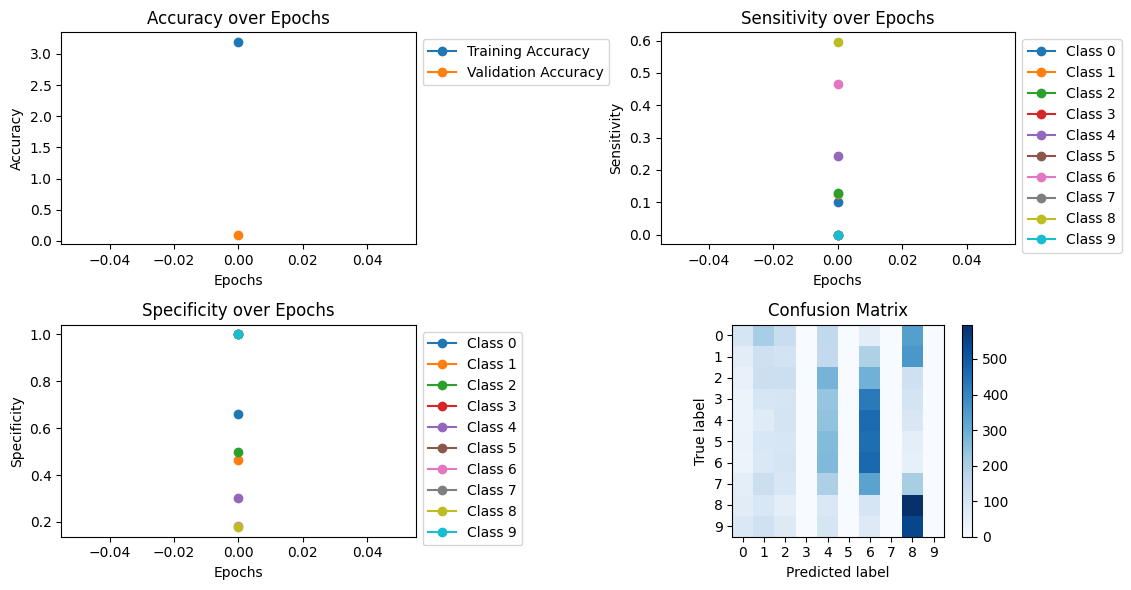

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\1.pth
Epoch 1 training accuracy: 3.2335
Epoch 1 validation accuracy: 0.1
Validation Sensitivity for epoch 1: [0.    0.232 0.    0.    0.    0.277 0.436 0.1   0.667 0.   ]
Validation Specificity for epoch 1: [1.         0.319202   1.         1.         1.         0.30990141
 0.21658986 0.49668874 0.13754647 1.        ]


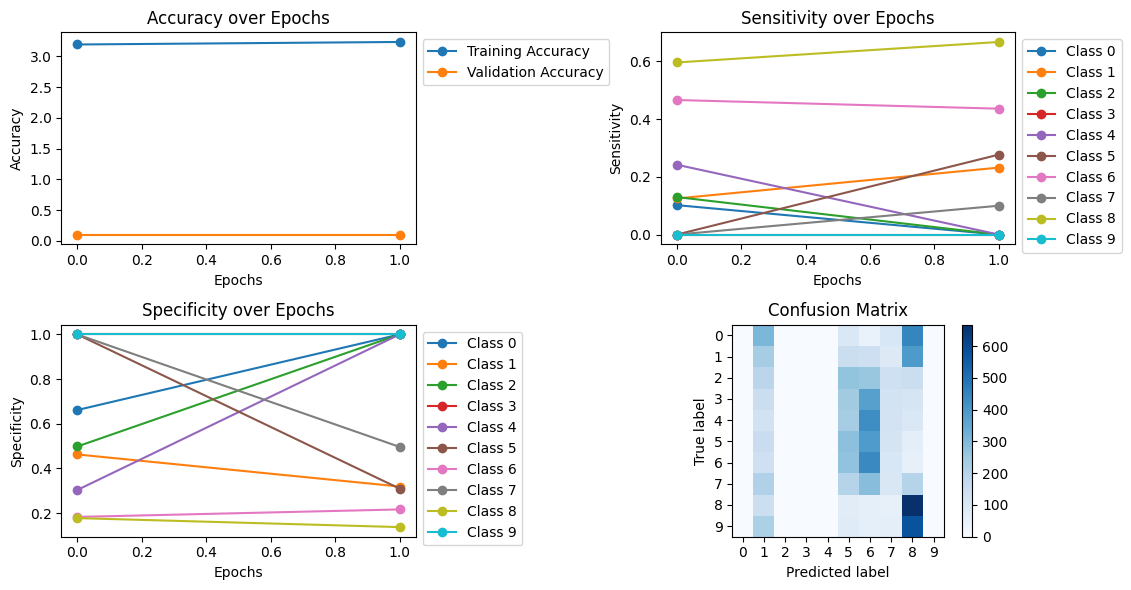

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\2.pth
Epoch 2 training accuracy: 3.26105
Epoch 2 validation accuracy: 0.1
Validation Sensitivity for epoch 2: [0.38  0.    0.181 0.    0.    0.    0.698 0.    0.58  0.   ]
Validation Specificity for epoch 2: [0.24275646 1.         0.37142857 1.         1.         1.
 0.08096515 1.         0.22913257 1.        ]


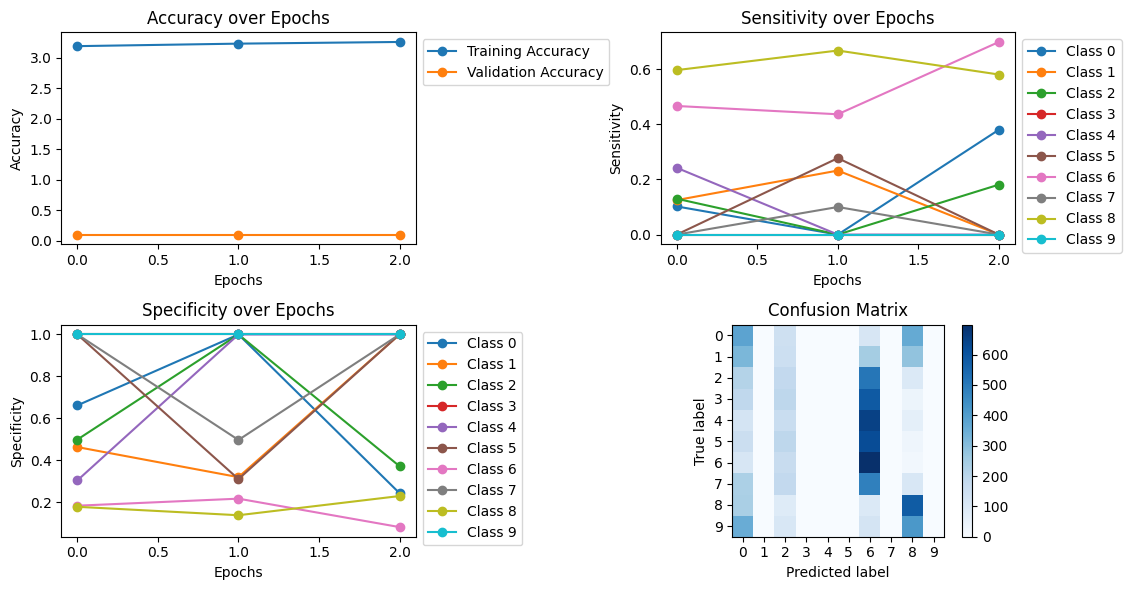

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\3.pth
Epoch 3 training accuracy: 3.266125
Epoch 3 validation accuracy: 0.1
Validation Sensitivity for epoch 3: [0.225 0.016 0.103 0.    0.    0.271 0.417 0.    0.736 0.   ]
Validation Specificity for epoch 3: [0.32604123 0.82205514 0.5254833  1.         1.         0.31750871
 0.25150992 1.         0.10276372 1.        ]


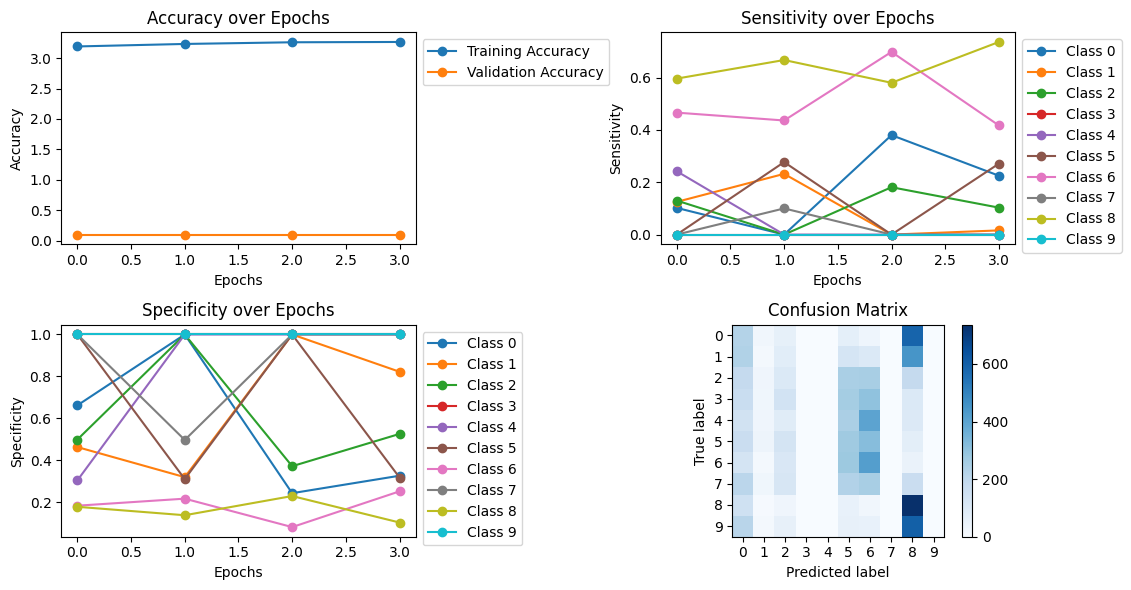

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\4.pth
Epoch 4 training accuracy: 3.2636
Epoch 4 validation accuracy: 0.1
Validation Sensitivity for epoch 4: [0.    0.145 0.047 0.094 0.    0.03  0.832 0.    0.386 0.243]
Validation Specificity for epoch 4: [1.         0.53039702 0.66736695 0.51360544 1.         0.86529884
 0.03733333 1.         0.46906035 0.4421729 ]


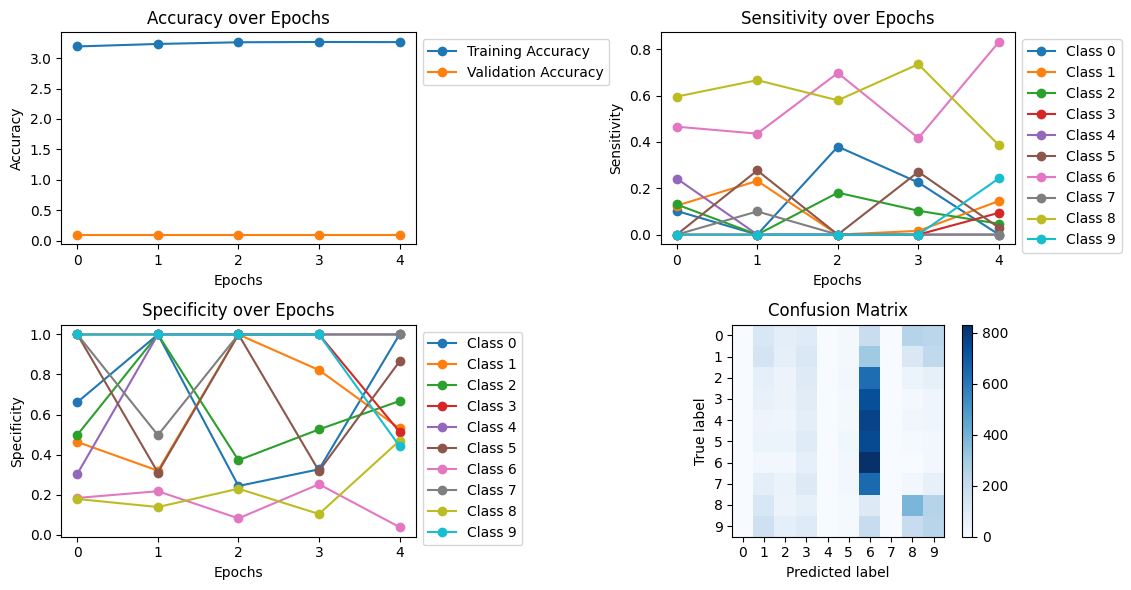

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\5.pth
Epoch 5 training accuracy: 3.30025
Epoch 5 validation accuracy: 0.1
Validation Sensitivity for epoch 5: [0.139 0.127 0.036 0.    0.    0.236 0.789 0.    0.426 0.05 ]
Validation Specificity for epoch 5: [0.60633803 0.59590444 0.69703543 1.         1.         0.29692965
 0.05252676 1.         0.40680369 0.84444444]


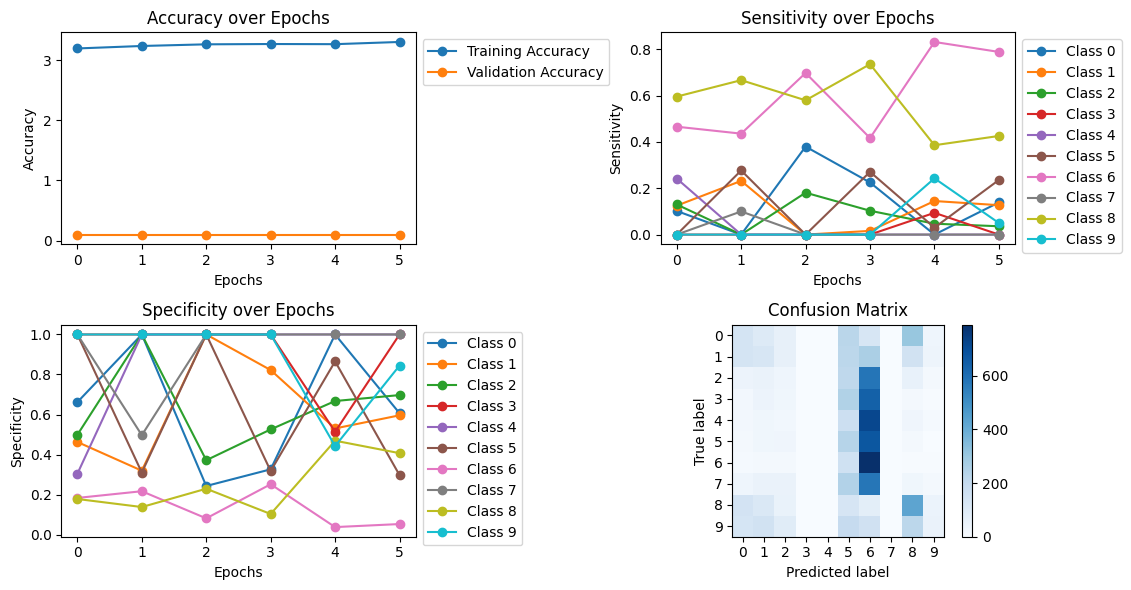

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\6.pth
Epoch 6 training accuracy: 3.28045
Epoch 6 validation accuracy: 0.1
Validation Sensitivity for epoch 6: [0.115 0.197 0.    0.259 0.    0.07  0.625 0.    0.638 0.   ]
Validation Specificity for epoch 6: [0.55835962 0.38439445 1.         0.32889481 1.         0.73055774
 0.12630515 1.         0.17894217 1.        ]


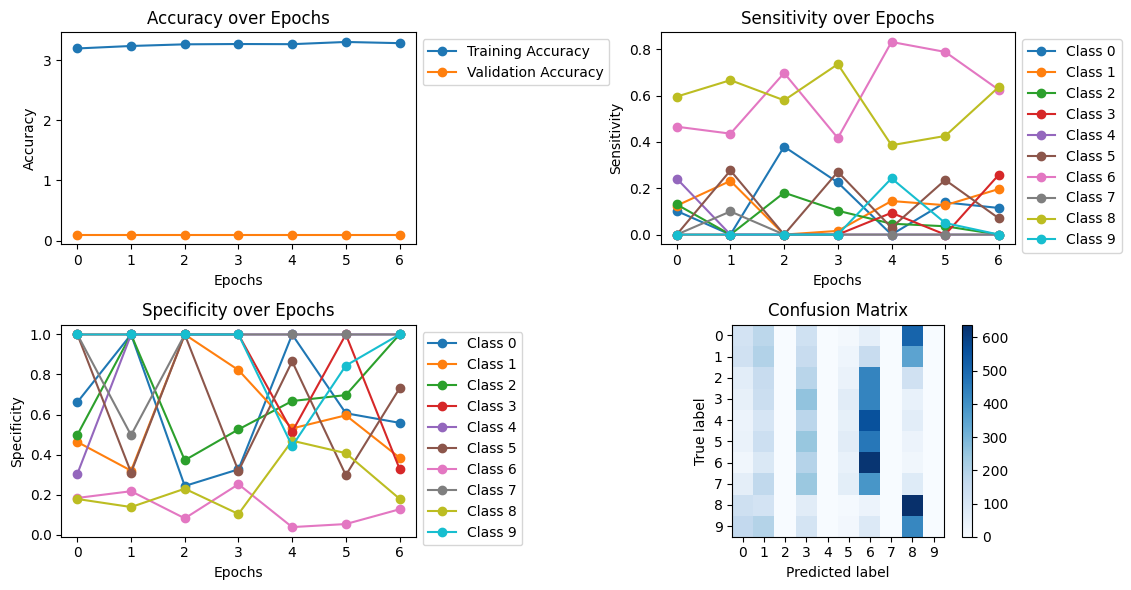

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\7.pth
Epoch 7 training accuracy: 3.2875
Epoch 7 validation accuracy: 0.1
Validation Sensitivity for epoch 7: [0.    0.141 0.    0.06  0.013 0.302 0.62  0.    0.562 0.27 ]
Validation Specificity for epoch 7: [1.         0.49854904 1.         0.69940476 0.8844086  0.29119733
 0.12973711 1.         0.24886364 0.40668524]


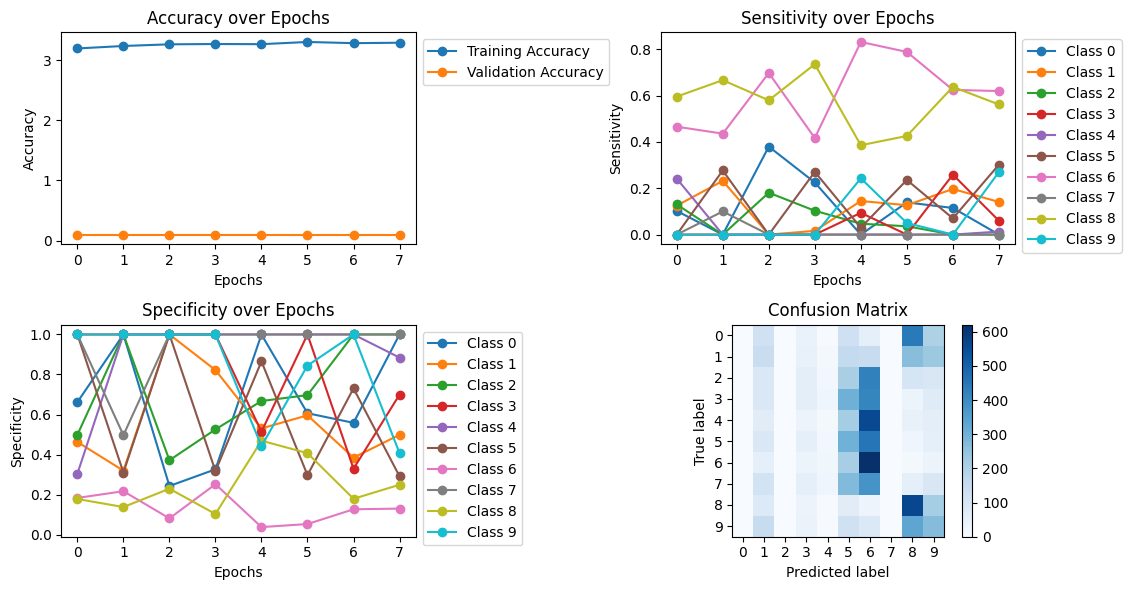

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\8.pth
Epoch 8 training accuracy: 3.28275
Epoch 8 validation accuracy: 0.1
Validation Sensitivity for epoch 8: [0.    0.18  0.    0.    0.    0.33  0.62  0.    0.558 0.268]
Validation Specificity for epoch 8: [1.         0.40117417 1.         1.         1.         0.25838797
 0.1303155  1.         0.25042493 0.41355932]


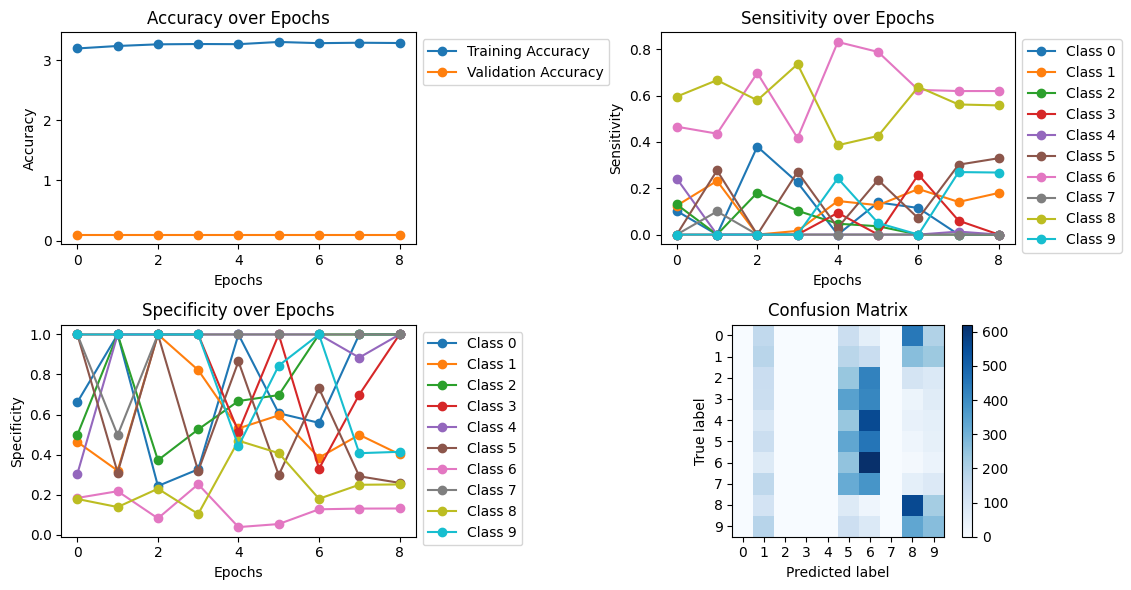

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/rel_reps/cifar\9.pth
Epoch 9 training accuracy: 3.297425
Epoch 9 validation accuracy: 0.1
Validation Sensitivity for epoch 9: [0.    0.116 0.    0.    0.    0.405 0.437 0.    0.794 0.115]
Validation Specificity for epoch 9: [1.         0.43037975 1.         1.         1.         0.21372126
 0.27330097 1.         0.0755132  0.53963415]


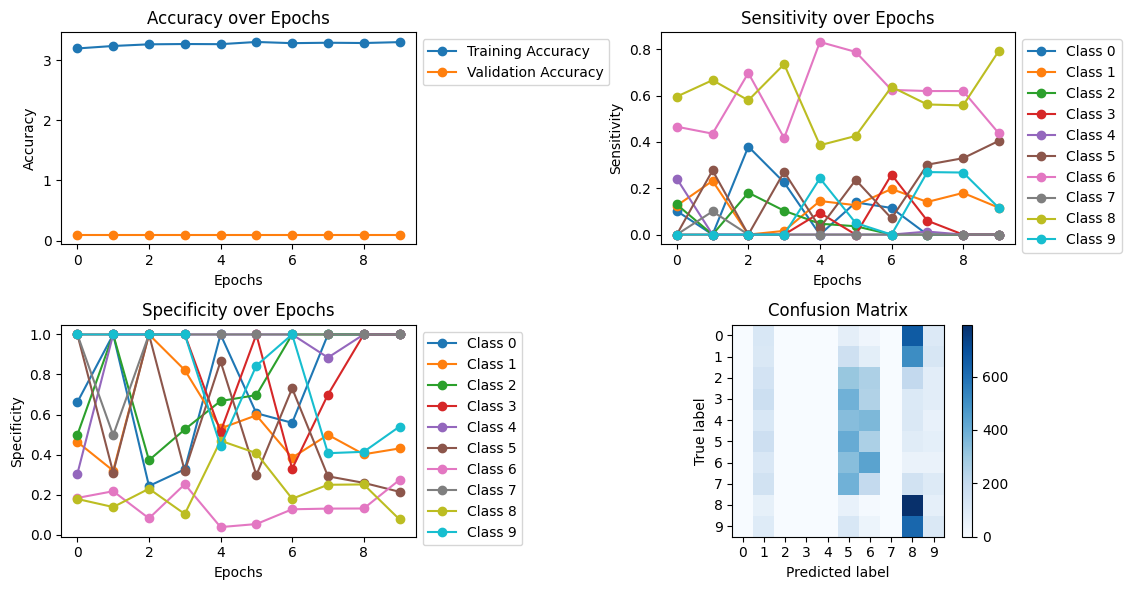

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FFNN(num_classes=10, in_channels=3)

train_accs, test_accs, confusion_matrices, sensitivities, specificities = train(
    model=model,
    train_dataloader=dataloader_train_cifar_rel_rep,
    epochs=10,
    val_dataloader=dataloader_test_cifar_rel_rep,
    run_filepath="models/rel_reps/cifar",
    plot=True,
    overwrite=True
)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/cifar_cnn\0.pth
Epoch 0 training accuracy: 0.427175
Training Confusion Matrix for epoch 0:
[[1849  239  277   81   88  104   55  116  947  241]
 [ 153 2214   22   49   28   51   90   87  319  978]
 [ 463   74  975  336  708  460  452  283  163  100]
 [ 131   95  394  818  300 1122  565  323  106  143]
 [ 216   67  682  230 1119  343  611  562   78   85]
 [  86   61  358  715  291 1641  300  449   54  102]
 [  56   98  302  317  437  230 2224  147   53  133]
 [ 115   97  190  232  332  524  192 2017   42  205]
 [ 883  338  111   67   26   64   58   28 2145  249]
 [ 199  988   38   73   28   57  130  181  260 2085]]
Epoch 0 validation accuracy: 0.5055
Validation Sensitivity for epoch 0: [0.323 0.618 0.127 0.145 0.576 0.183 0.595 0.817 0.854 0.817]
Validation Specificity for epoch 0: [0.84730914 0.71268657 0.84104046 0.81428571 0.27550357 0.87849462
 0.61270802 0.13071429 0.13984674 0.20492721]


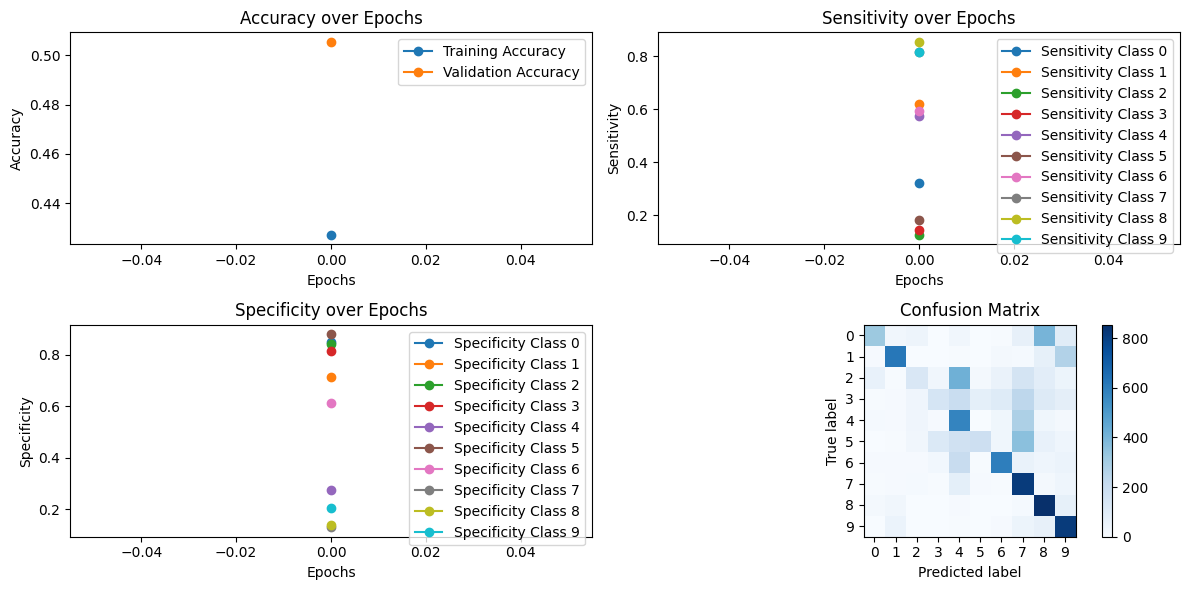

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/cifar_cnn\1.pth
Epoch 1 training accuracy: 0.613075
Training Confusion Matrix for epoch 1:
[[2665   95  335   81   76   23   33   94  439  156]
 [  91 3158   10   26   14   12   44   25  151  460]
 [ 398   33 1754  327  583  282  298  180  104   55]
 [ 109   34  384 1414  238 1001  445  175  109   88]
 [ 159   27  577  235 1999  156  308  474   29   29]
 [  50   23  283  862  243 2026  175  322   30   43]
 [  45   30  194  392  311   85 2803   35   54   48]
 [  71   25  125  184  332  387   30 2675   25   92]
 [ 401  183   56   77   14   22   39   16 3026  135]
 [ 159  455   17   86   21   30   46   79  143 3003]]
Epoch 1 validation accuracy: 0.6542
Validation Sensitivity for epoch 1: [0.531 0.842 0.563 0.298 0.637 0.46  0.748 0.787 0.869 0.807]
Validation Specificity for epoch 1: [0.74562798 0.39108911 0.44141414 0.69781312 0.39977974 0.68527919
 0.48742747 0.34918033 0.24394786 0.36622391]


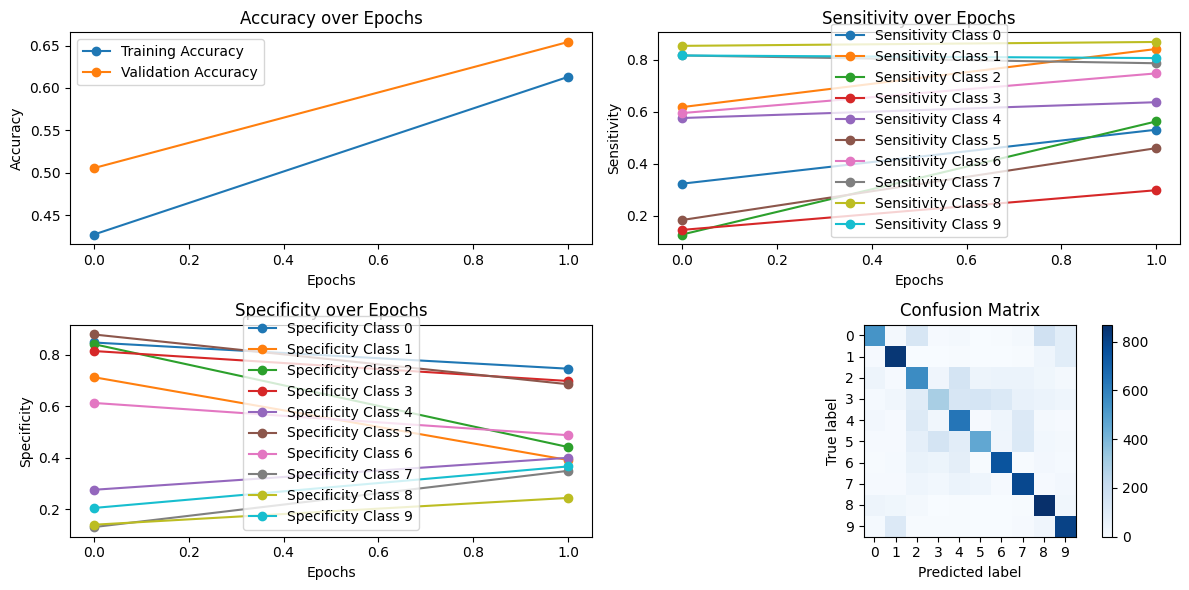

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/cifar_cnn\2.pth
Epoch 2 training accuracy: 0.70945
Training Confusion Matrix for epoch 2:
[[2976   67  244   73   90   15   23   69  306  134]
 [  58 3425   11   23    7   11   25   13  107  311]
 [ 297   14 2351  234  434  187  245  144   66   42]
 [  95   24  301 1946  239  748  341  158   89   56]
 [ 138   10  367  230 2609  118  207  280   19   15]
 [  30   16  206  824  226 2312  144  245   19   35]
 [  22   17  190  300  211   84 3102   14   30   27]
 [  68    7  133  163  254  232   21 2999   15   54]
 [ 250  101   45   61   19   17   23    8 3357   88]
 [ 134  329   16   56    9   19   34   48   93 3301]]
Epoch 2 validation accuracy: 0.6922
Validation Sensitivity for epoch 2: [0.736 0.898 0.527 0.548 0.675 0.23  0.853 0.891 0.799 0.765]
Validation Specificity for epoch 2: [0.60411899 0.28254848 0.68650218 0.42681775 0.42428198 0.95652174
 0.24297521 0.15266106 0.65472313 0.56900726]


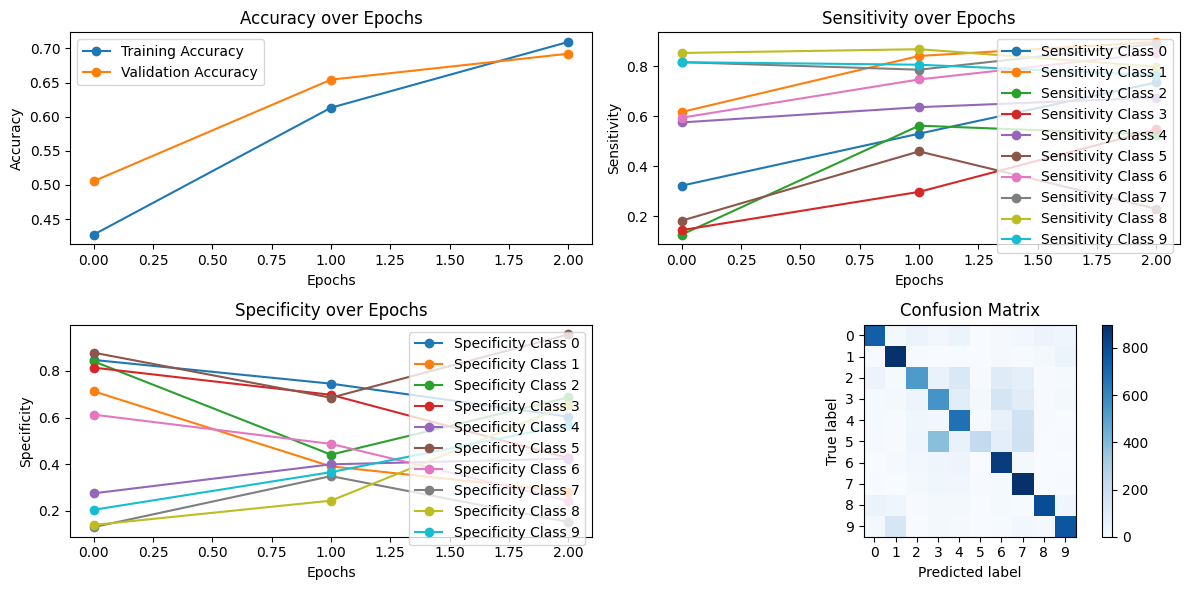

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/cifar_cnn\3.pth
Epoch 3 training accuracy: 0.7658
Training Confusion Matrix for epoch 3:
[[3236   38  192   67   73   14   21   36  214  106]
 [  40 3582   10   19    6   10   15    7   86  216]
 [ 258   16 2670  209  358  138  201   94   46   24]
 [  92   18  238 2301  236  642  264  110   47   49]
 [  90    5  281  206 2916   86  158  220   19   12]
 [  27    6  159  767  206 2546   89  213   22   22]
 [  19   17  177  263  156   65 3230   12   34   24]
 [  55    6   95  153  222  170   18 3192    8   27]
 [ 199   81   29   51   16   10   23    7 3482   71]
 [ 107  231   15   48   13   12   20   34   82 3477]]
Epoch 3 validation accuracy: 0.7245
Validation Sensitivity for epoch 3: [0.696 0.897 0.585 0.509 0.774 0.461 0.815 0.808 0.924 0.776]
Validation Specificity for epoch 3: [0.57904762 0.30116959 0.5540721  0.56242841 0.33681073 0.79970326
 0.44578313 0.47407407 0.15510204 0.61202186]


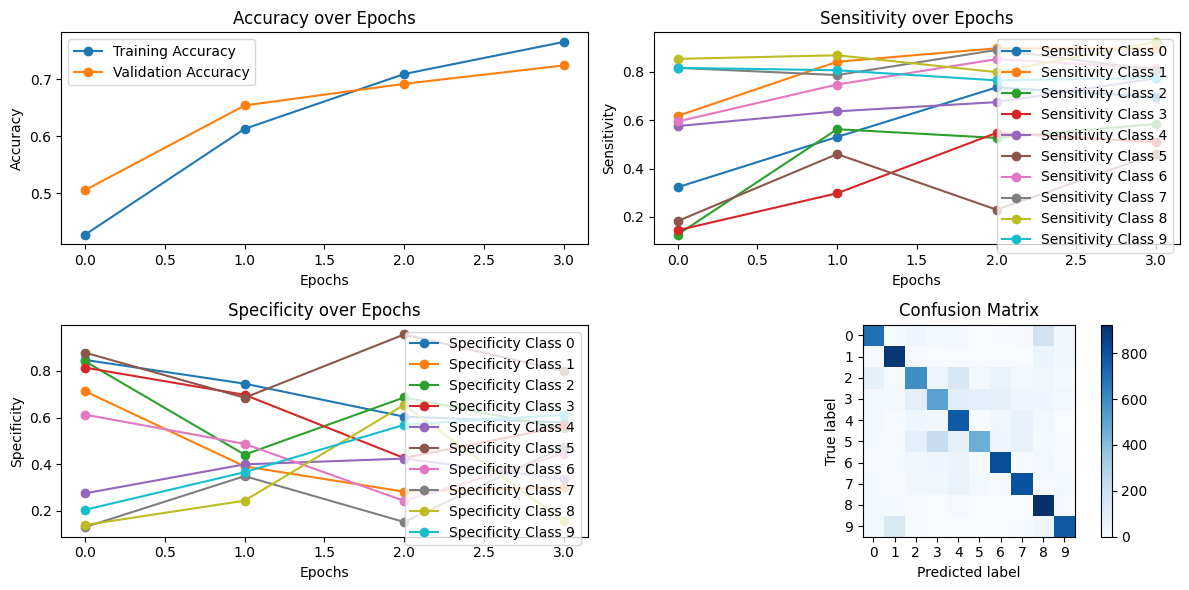

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/cifar_cnn\4.pth
Epoch 4 training accuracy: 0.8082
Training Confusion Matrix for epoch 4:
[[3373   26  171   56   53   13   11   33  171   90]
 [  28 3658    0   16    4    5   15    0   72  193]
 [ 219    8 2914  216  261  116  158   73   34   15]
 [  86   12  247 2532  139  587  209   99   55   31]
 [  69    2  216  158 3144   86  117  172   20    9]
 [  27    6  136  650  149 2789  100  174   14   12]
 [  19   17  148  216  122   63 3374    4   20   14]
 [  34    4   73  142  163  133    9 3357    9   22]
 [ 145   63   17   37   17    9   17    8 3608   48]
 [  98  204   14   32    9   14   13   22   54 3579]]
Epoch 4 validation accuracy: 0.7442
Validation Sensitivity for epoch 4: [0.813 0.883 0.667 0.564 0.599 0.625 0.854 0.802 0.856 0.779]
Validation Specificity for epoch 4: [0.41834452 0.45882353 0.45244565 0.46781116 0.70474517 0.56904401
 0.29025845 0.48648649 0.50526316 0.68421053]


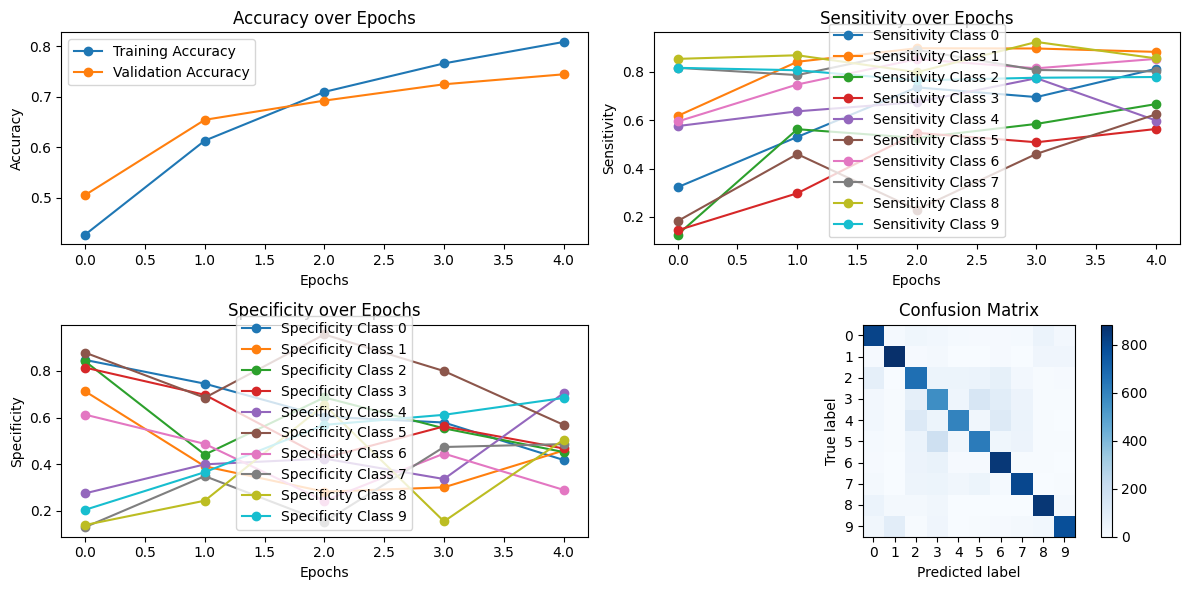

  0%|          | 0/1250 [00:00<?, ?it/s]

Model saved to models/cifar_cnn\5.pth
Epoch 5 training accuracy: 0.845225
Training Confusion Matrix for epoch 5:
[[3499   22  124   40   50   11   13   19  148   71]
 [  21 3757    3    9    7    6   10    2   44  132]
 [ 193    3 3121  177  215  100  120   56   19   10]
 [  63   14  194 2818  124  461  169   87   33   34]
 [  60    2  190  140 3295   66   91  133   15    1]
 [  21    3  113  575  132 2980   70  139   12   12]
 [  14   11  120  161   81   55 3515    8   18   14]
 [  24    1   71  111  119  108    4 3488    6   14]
 [ 144   54   16   33    9    4   10    2 3653   44]
 [  80  149   13   24    4    5   16   17   48 3683]]
Epoch 5 validation accuracy: 0.7375
Validation Sensitivity for epoch 5: [0.813 0.821 0.657 0.642 0.662 0.608 0.721 0.716 0.878 0.857]
Validation Specificity for epoch 5: [0.36030829 0.69649805 0.46102151 0.35166994 0.59090909 0.59574468
 0.6975     0.75531915 0.3495702  0.40056022]


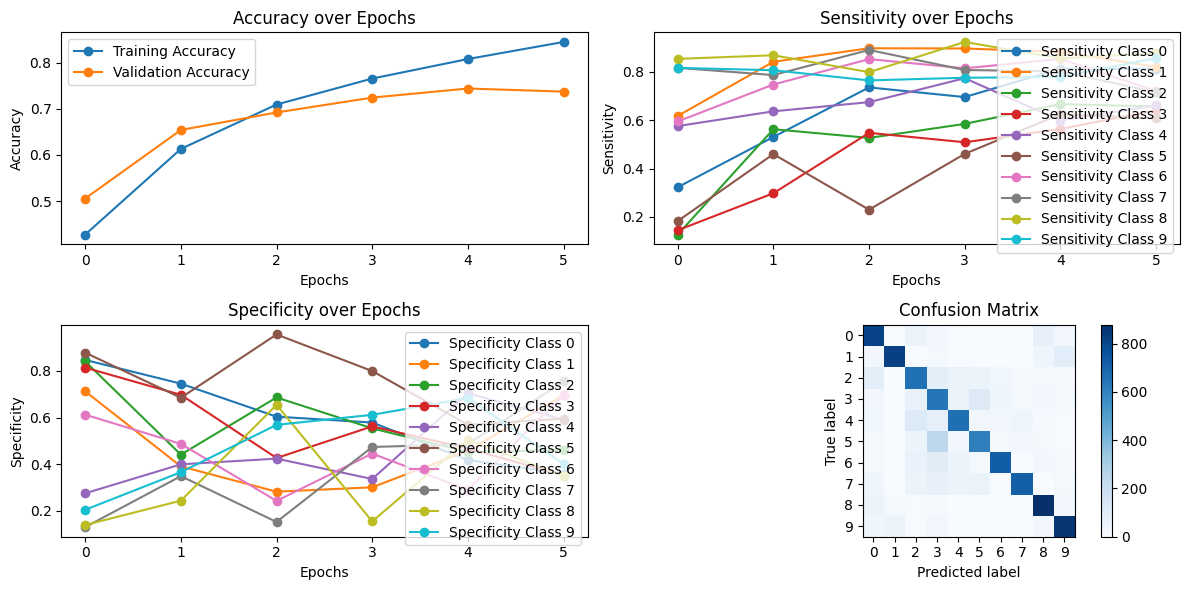

  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN(num_classes=10, in_channels=3)

train_accs, test_accs, confusion_matrices, sensitivities, specificities = train(
    model=model,
    train_dataloader=dataloader_train_cifar,
    epochs=10,
    val_dataloader=dataloader_test_cifar,
    run_filepath="models/cifar_cnn",
    plot=True
)